# Simulation of an epidemic model

### Markov model :
* $(x,y) \rightarrow (x+1,y)$ at rate $\mu x$ (births of susceptibles);
* $(x,y) \rightarrow (x-1,y+1)$ at rate $\beta x y$ (infections);
* $(x,y) \rightarrow (x,y-1)$ at rate $\gamma y$ (death of infections);

### Lotka - Volterra model associated 
First order deterministic approximation:
\begin{align}
  d x_t = \mu x_t - \beta x_t y_t \\
  d y_t = \beta x_t y_t -\gamma y_t.
\end{align}

Fix point :
$$
  x_\star = \frac{\gamma}{\beta} \quad\text{and}\quad y_\star = \frac{\mu}{\beta}. 
$$

Conserve quantity:
\begin{equation}
  \beta(x+y) - \gamma \log(x) - \mu\log(y).
\end{equation}

### Markov model renormalised :
* $(x,y) \rightarrow (x+\tfrac{1}{N},y)$ at rate $\mu x N$ (births of susceptibles);
* $(x,y) \rightarrow (x-\tfrac{1}{N},y+\tfrac{1}{N})$ at rate $\beta' x y N$ (infections);
* $(x,y) \rightarrow (x,y-\tfrac{1}{N})$ at rate $\gamma y N$ (death of infections);

where the $\beta' = \beta N$.

In [1]:
%matplotlib inline
import numpy as np

import math
import random
import time
import numba

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import matplotlib.mlab as mlab

matplotlib.pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Model next step.
@numba.jit(nopython=True)
def model_next_step(t, x, y, mu, beta, gamma):

    if x > 0 and y > 0:
        t_arrival = random.expovariate(mu*x)
        t_infection = random.expovariate(beta*x*y)
        t_death = random.expovariate(gamma*y)

        if t_arrival <= t_infection and t_arrival <= t_death:
            return (t+t_arrival, x+1, y)
        elif t_infection <= t_death:
            return (t+t_infection, x-1, y+1)
        else:
            return (t+t_death, x, y-1)
    elif y > 0:
        t_death = random.expovariate(gamma*y)
        return (t+t_death, x, y-1)
    else:
        return(t, x, y)


# Simulation of the model
@numba.jit(nopython=True)
def simulate_model(_x0, _y0, mu, gamma, beta, seed=0):
    random.seed(int(seed))
    vt = [0.]
    vx = [_x0]
    vy = [_y0]

    (t, x, y) = model_next_step(vt[-1], vx[-1], vy[-1], mu, gamma, beta)
    while x > 0 and y > 0:
        vt.append(t)
        vx.append(x)
        vy.append(y)
        (t, x, y) = model_next_step(vt[-1], vx[-1], vy[-1], mu, gamma, beta)

    return (np.array(vt), np.array(vx), np.array(vy))

In [3]:
# Compute conserve quantity
# Note: numba vectorisation much faster.
@numba.vectorize([numba.float32(numba.float32, numba.float32),
                  numba.float64(numba.float64, numba.float64)])
def f_cons_qty(x, y):
    return betap * (x+y) - gamma*math.log(x) - mu*math.log(y)
vf_cons_qty = np.vectorize(f_cons_qty)

In [4]:
# Scaling 
N = 100

# Model parameters
mu = 1.
gamma = 5.
betap = 0.1
beta = betap / N

# Fixed point
xstar = gamma / beta
ystar = mu / beta
# Initial values: start from the fixed point.
x0 = xstar
y0 = ystar

## Trajectories and phase simulations

In [5]:
# Make a few simulations.
nb = 1
(vt, vx, vy) = simulate_model(x0, y0, mu, beta, gamma, seed=time.time()*10)

In [6]:
# Plotting grid
xdelta = 0.5
ydelta = 0.5
xmax = 150
ymax = 100
x = np.arange(xdelta, xmax, xdelta)
y = np.arange(ydelta, ymax, ydelta)
X, Y = np.meshgrid(x, y)

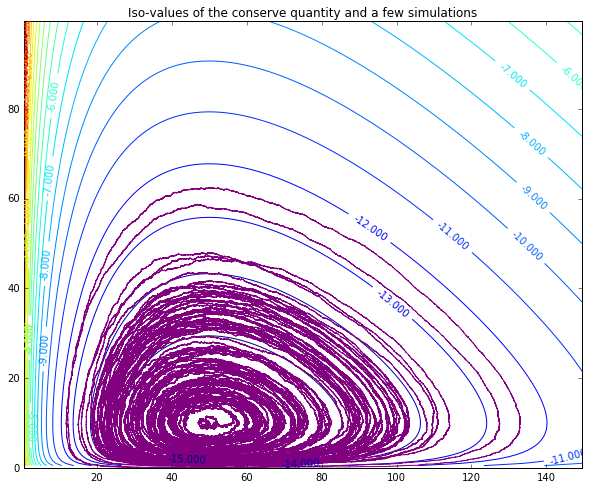

In [7]:
# Plotting initialisation
plt.figure()

# Plot conserve quantity of the Lotka--Volterra model
nlines = 30
cons_qty = f_cons_qty(X, Y)
cs_cons_qty = plt.contour(X, Y, cons_qty, nlines)
plt.clabel(cs_cons_qty, inline=1, fontsize=10)

# Plot simulation
plt.plot(vx / N, vy / N, linewidth=1, color='purple')
# plt.plot(np.array([xstar,10,5]), np.array([ystar,10,10]))

# Final plot
plt.title('Iso-values of the conserve quantity and a few simulations')
plt.show()

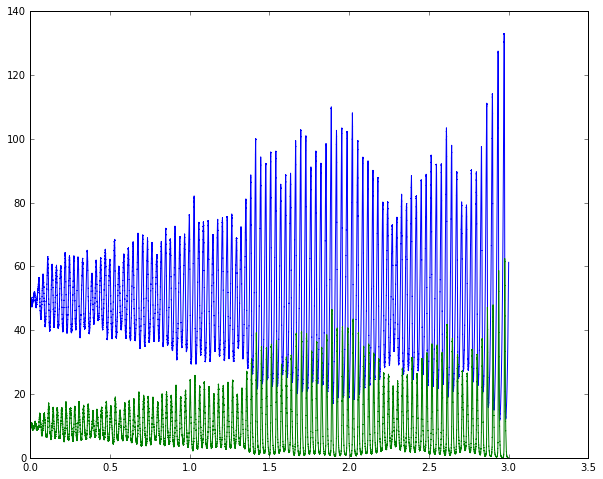

In [8]:
plt.plot(vt / N, vx / N)
plt.plot(vt / N, vy / N)
plt.show()

## Extinction time distribution

In [9]:
# (Simple) simulation of the model
@numba.jit(nopython=True)
def simple_simulate_model(_x0, _y0, mu, gamma, beta):
    (t, x, y) = (0., _x0, _y0)    
    while x > 0 and y > 0:
        (t, x, y) = model_next_step(t, x, y, mu, gamma, beta)

    return (t, x, y)

# Simulations
@numba.jit(nopython=True)
def simulations(nb, mu, beta, gamma, seed):
    random.seed(int(seed))
    data = np.zeros(nb, np.float64)
    for i in range(nb):
        (t, x, y) = simple_simulate_model(x0, y0, mu, beta, gamma)
        data[i] = t
    return data

In [10]:
# Scaling 
N = 10000

# Model parameters
mu = 1.
gamma = 10.
betap = 0.1
beta = betap / N

# Simulation data
nb_sim = 5000
data1 = simulations(nb_sim, mu, beta, gamma, time.time())

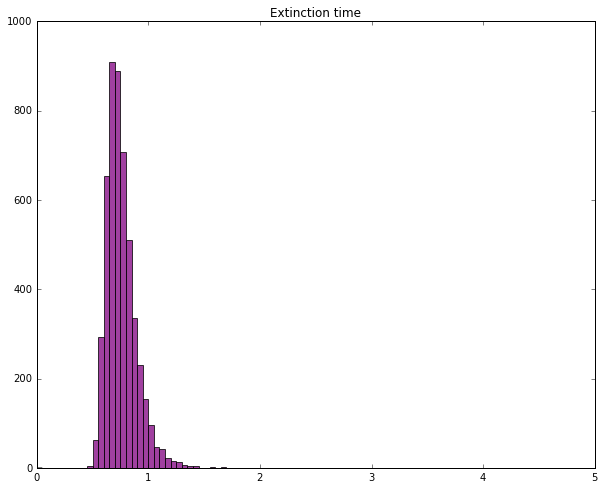

In [11]:
plt.hist(data1, bins=100, range=[0,5], facecolor='purple', alpha=0.75)
plt.title('Extinction time')
plt.show()

In [12]:
N = 10000
nb_sim = 10000

# Change a bit the gamma parameter.
mu = 1.
gammas = [5., 10., 20.]
data = []

for g in gammas:
    data.append( simulations(nb_sim, mu, beta, g, time.time()) ) 

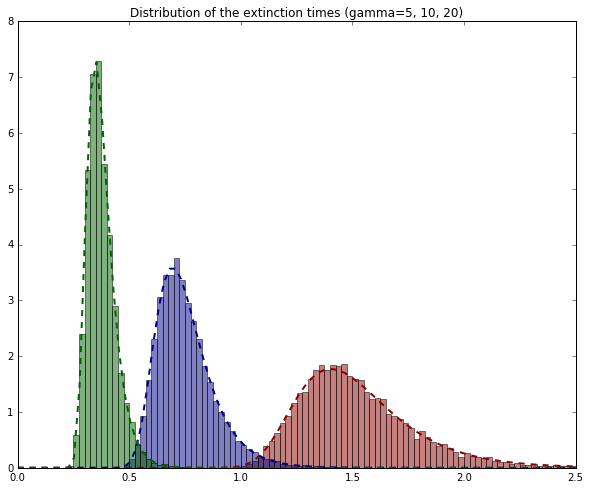

In [13]:
euler_ct = 0.577215664901532860
def density_gumbel(x, loc, scale):
    p = np.exp(-(x - loc) / scale) / scale * np.exp(-np.exp(-(x - loc) / scale))
    return p

prange = [0., 2.5]
x = np.linspace(0., 2.5, 100)
colors = ['darkred', 'darkblue', 'darkgreen']
for i, g in enumerate(gammas):
    # Simulation distribution
    plt.hist(data[i], normed=True, bins=100, range=prange, facecolor=colors[i], alpha=0.5)
    
    # Gumbel distribution fitting ?
    scale = data[i].std() * np.sqrt(6) / np.pi
    loc = data[i].mean() - euler_ct * scale
    d = density_gumbel(x, loc, scale)  

    plt.plot(x, d, ls='--', color=colors[i], linewidth=2, alpha=1)
    
    
plt.title('Distribution of the extinction times (gamma=5, 10, 20)')
plt.show()

In [14]:
# Pot pourri
# line_colours = ('BlueViolet', 'Crimson', 'ForestGreen', 'Indigo', 'Tomato', 'Maroon')
# line_widths = (1, 1.5, 2, 2.5, 3, 3.5)
# plt.scatter(xstar, ystar, marker='o', c='b', s=40)
# plt.scatter([xstar,10], [ystar,10], marker='o', c='b', s=40, linewidths=1)
# plt.plot(np.array([xstar,10,5]), np.array([ystar,10,10]))

# gamma_cte = 0.57721566490153286060
# x = np.linspace(0, 2.5, 100)
# def density_gumbel(x, p1, p2):
#     p = np.exp(-(x - p1) / p2) / p2 * np.exp(-np.exp(-(x - p1) / p2))
#     return p
# p2 = data2.std() * 6 / np.pi
# p1 = data2.mean() - gamma_cte * p2
# d1 = density_gumbel(x, p1, p2)        
# plt.hist(data2, normed=True, bins=80, range=prange, facecolor='Indigo', alpha=0.5)
# plt.plot(x, d1)
